# Imports

In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import glob
import cv2

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import tqdm
from PIL import Image

train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

**Sections of this kernel**
- EDA
- Preprocessing
- 1st iteration


# EDA


## Main goal

The main task is to detect metastases in digital histopathology images of a 96 x 96px size. The images are taken from glass slide microscopes of stained lymph nodes. The major challenge is the presence of tiny metastases that can be as small as single cells and hard to identify. The images use Hematoxylin and Eosin (H&E) staining, resulting in various shades of pink, blue, and violet. Hematoxylin stains nucleic acids blue, whereas Eosin paints proteins in pink shades. The lymph nodes that are small glands filtering the fluid in the lymphatic system are often where breast cancer first spreads. Evaluation of lymph node metastases is part of the TNM classification process, a globally accepted system for understanding the extent of the spread of cancer. This process can be time-consuming and laborious for pathologists due to the large area of tissue they must examine, often resulting in smaller metastases being overlooked.

## Data loading


In [2]:
DATA_PATH = "/kaggle/input/histopathologic-cancer-detection/"
DATA_PATH = "data"

In [64]:
data = pd.read_csv(f"{DATA_PATH}/train_labels.csv")
train = f"{DATA_PATH}/train"
test = f"{DATA_PATH}/test"
data["label"].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

It means that the dataset is imbalanced

In [4]:
def map_labels(label):
    if label == 0:
        return "non-cancer"
    elif label == 1:
        return "cancer"

data["human-readable"] = data["label"].apply(map_labels)

In [5]:
def load_image(path):
    rgb_repr = cv2.imread(path)
    r, g, b = cv2.split(rgb_repr)[::-1]
    rgb_img = cv2.merge([r, g, b])  # useful for visibility
    return rgb_img

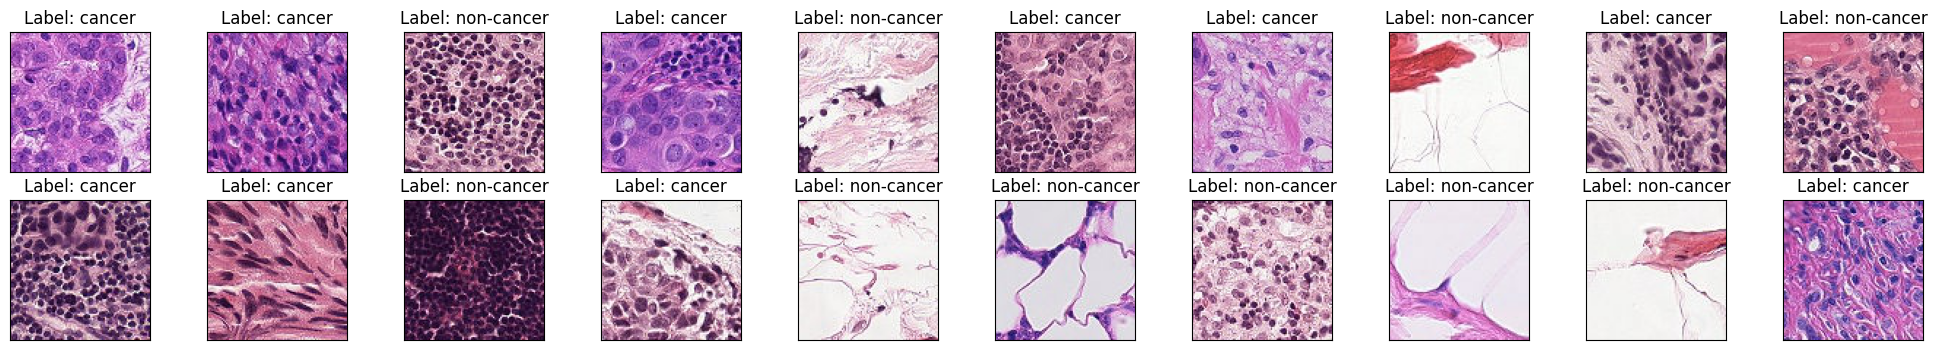

In [6]:
def visualize_random_images(path, labels, num_images=20, figsize=(25, 4)):
    fig = plt.figure(figsize=figsize)
    train_imgs = glob.glob(path + "/*")
    for idx, img in enumerate(np.random.choice(train_imgs, num_images)):
        ax = fig.add_subplot(2, num_images // 2, idx + 1, xticks=[], yticks=[])
        im = load_image(img)
        plt.imshow(im)
        lab = labels.loc[
            labels["id"] == os.path.basename(img).split(".")[0], "human-readable"
        ].values[0]
        ax.set_title(f"Label: {lab}")
    plt.show()

visualize_random_images(f"{DATA_PATH}/train", data)

## Preprocessing

In [65]:
data

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


In [8]:
from enum import Enum

DEBUG_SCOPE = 5048

DEFAULT_LABEL = 0


class DataType(Enum):
    TRAIN = "train"
    TEST = "test"
    VALIDATION = "validation"  # optional


class CustomDataset(Dataset):
    def __init__(
        self,
        data_pattern,
        datatype=DataType.TRAIN,
        transform=[],
        labels_dict={},
    ):
        self.datatype = datatype
        self.files = glob.glob(data_pattern)
        self.transformations_list = transform
        if self.datatype == DataType.TRAIN:
            self.ids = [os.path.basename(os.path.splitext(i)[0]) for i in self.files]
            new_data = pd.DataFrame(data)
            new_data = new_data.set_index("id")
            self.labels = new_data[new_data.index.isin(self.ids)]["label"].values
            print(self.labels)
            assert len(self.labels) == len(self.files)
        else:
            self.ids = [os.path.basename(os.path.splitext(i)[0]) for i in self.files]
            self.labels = [DEFAULT_LABEL for _ in range(len(self.files))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            img = load_image(self.files[idx])
        except:
            print(idx)
        image = self.transformations_list(image=img)["image"]
        if self.datatype == DataType.TRAIN:
            label = self.labels[idx]
        else:
            label = 0
        return image, label

In [9]:
img_class_dict = {k: v for k, v in zip(data.id, data.label)}
tr, val = train_test_split(
    data[:DEBUG_SCOPE].label, stratify=data[:DEBUG_SCOPE].label, test_size=0.1
)

In [75]:
# data_transforms = albumentations.Compose(
#     [
#         albumentations.Resize(224, 224),
#         albumentations.HorizontalFlip(),
#         albumentations.RandomBrightnessContrast(),
#         albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
#         albumentations.HueSaturationValue(),
#         albumentations.Normalize(),
#         ToTensorV2(),
#     ]
# )
# data_transforms_test = albumentations.Compose(
#     [albumentations.Resize(224, 224), albumentations.Normalize(), ToTensorV2()]
# )

# dataset = CustomDataset(
#     data_pattern=f"{DATA_PATH}/train/*.tif",
#     datatype=DataType.TRAIN,
#     transform=data_transforms,
#     labels_dict=img_class_dict,
# )
# test_set = CustomDataset(
#     data_pattern=f"{DATA_PATH}/test/*.tif",
#     datatype="test",
#     transform=data_transforms_test,
# )
# train_sampler = SubsetRandomSampler(list(tr.index))
# valid_sampler = SubsetRandomSampler(list(val.index))
# batch_size = 128
# num_workers = 20
# train_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
# )
# valid_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
# )
# test_loader = torch.utils.data.DataLoader(
#     test_set, batch_size=batch_size, num_workers=num_workers
# )

In [77]:
class Transformations:
    def __init__(self, dimension=224):
        self.dimension = dimension

    def base_transformations(self):
       return [albumentations.Resize(self.dimension, self.dimension), albumentations.Normalize()]

    def extra_transformations(self):
       return [
           albumentations.HorizontalFlip(),
           albumentations.RandomBrightnessContrast(),
           albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
           albumentations.HueSaturationValue(),
       ]

    def data_transforms(self):
       print(self.base_transformations() + [ToTensorV2()])
       return albumentations.Compose(self.base_transformations() + self.extra_transformations() + [ToTensorV2()]) 

    def data_transforms_test(self):
       print(self.base_transformations() + [ToTensorV2()])
       return albumentations.Compose(self.base_transformations() + [ToTensorV2()])

transforms = Transformations()

dataset = CustomDataset(
    data_pattern=f"{DATA_PATH}/train/*.tif",
    datatype=DataType.TRAIN,
    transform=transforms.data_transforms(),
    labels_dict=img_class_dict,
)
test_set = CustomDataset(
    data_pattern=f"{DATA_PATH}/test/*.tif",
    datatype="test",
)

class DataLoaderCreation:
    def __init__(self, data_set, batch_size=128, num_workers=20):
        self.data_set = data_set
        self.batch_size = batch_size
        self.num_workers = num_workers

    def create_dataloader(self, indices):
        sampler = SubsetRandomSampler(indices)
        return torch.utils.data.DataLoader(
            self.data_set, batch_size=self.batch_size, sampler=sampler, num_workers=self.num_workers
        )

dataloader_train = DataLoaderCreation(dataset)
dataloader_test = DataLoaderCreation(test_set)

train_loader = dataloader_train.create_dataloader(list(tr.index))
valid_loader = dataloader_train.create_dataloader(list(val.index))
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers
)

[Resize(p=1.0, height=224, width=224, interpolation=1), Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, normalization='standard'), ToTensorV2(p=1.0, transpose_mask=False)]
[0 1 0 ... 0 0 1]


In [68]:
model_conv = torchvision.models.resnet50(pretrained=True)
for i, param in model_conv.named_parameters():
    param.requires_grad = False

/media/veracrypt4/repos/kaggle-cnn/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/veracrypt4/repos/kaggle-cnn/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
criterion = nn.BCELoss()

In [70]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(2048, 2)

In [71]:
from torch.optim.lr_scheduler import CyclicLR

In [72]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.005, momentum=0.99)
scheduler = CyclicLR(optimizer, base_lr=0.010, max_lr=0.01,  mode='triangular2')
# scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [73]:
training = Training(
    model_conv,
    train_loader,
    valid_loader,
    criterion,
    optimizer,
    scheduler,
    n_epochs=1,
    patience=5,
)

training.fit()

36it [00:06,  5.49it/s]
/media/veracrypt4/repos/kaggle-cnn/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [41]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.conv_block_configs = [(3, 32), (32, 64), (64, 128), (128, 256), (256, 512)]

        self.conv_blocks = nn.ModuleList(
            [
                self._make_conv_block(in_channels, out_channels)
                for in_channels, out_channels in self.conv_block_configs
            ]
        )

        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, num_classes)

    def _make_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        x = self.avg(x)
        x = x.view(-1, 512 * 1 * 1)
        x = self.fc(x)
        return x

In [42]:
model_conv = CNN().cuda()

In [43]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.005, momentum=0.99)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [56]:
class Training:
    def __init__(
        self,
        model,
        train_loader,
        valid_loader,
        criterion,
        optimizer,
        scheduler,
        n_epochs=1,
        patience=5,
    ):
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.n_epochs = n_epochs
        self.patience = patience
        self.p = 0
        self.stop = False
        self.valid_loss_min = np.Inf

    def train_epoch(self):
        self.model.train()
        train_loss = []
        for batch_i, (data, target) in tqdm.tqdm(enumerate(self.train_loader)):
            data, target = data.cuda(), target.cuda()

            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output[:, 1], target.float())
            train_loss.append(loss.item())

            loss.backward()
            self.optimizer.step()

        return np.mean(train_loss)

    def validate_epoch(self):
        self.model.eval()
        val_loss = []

        for batch_i, (data, target) in enumerate(self.valid_loader):
            data, target = data.cuda(), target.cuda()
            output = self.model(data)

            loss = self.criterion(output[:, 1], target.float())

            val_loss.append(loss.item())

        return np.mean(val_loss)

    def fit(self):
        for epoch in range(1, self.n_epochs + 1):
            train_loss = self.train_epoch()
            valid_loss = self.validate_epoch()
            self.scheduler.step(valid_loss)
            if valid_loss <= self.valid_loss_min:
                torch.save(self.model.state_dict(), "model.pt")
                self.valid_loss_min = valid_loss
                self.p = 0

            if valid_loss > self.valid_loss_min:
                self.p += 1
                print(f"{self.p} epochs of increasing val loss")
                if self.p > self.patience:
                    print("Stopping training")
                    self.stop = True
                    break

            if self.stop:
                break

In [40]:
def get_preds(model, loader, device, n_pred=1):
    model.eval()
    preds = []
    for batch_i, (data, target) in tqdm.tqdm(enumerate(loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds.extend(output[:, n_pred].detach().cpu().numpy())
    return preds


preds = get_preds(model_conv, test_loader, "cuda:0", 1)

449it [00:22, 20.24it/s]


In [21]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [26]:
def generate_submission(test_set, preds, data_path, submission_file_name):
    test_preds = pd.DataFrame({"imgs": test_set.ids, "preds": preds})
    sub = pd.read_csv(f"{data_path}/sample_submission.csv")
    sub = pd.merge(sub, test_preds, left_on="id", right_on="imgs")
    sub = sub[["id", "preds"]]
    sub.columns = ["id", "label"]

    sub.to_csv(submission_file_name, index=False)
    print(f"Submission file saved as {submission_file_name}")

    return sub

In [27]:
generate_submission(test_set, preds, DATA_PATH, "sub.csv")

Submission file saved as sub.csv


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,-0.931386
1,95596b92e5066c5c52466c90b69ff089b39f2737,-0.901003
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,-0.951429
3,2c35657e312966e9294eac6841726ff3a748febf,-0.881028
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,-0.921489
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,-0.988405
57454,6f3977130212641fd5808210015a609c658dcbff,-0.894441
57455,46935f247278539eca74b54d07d666efb528a753,-0.979838
57456,a09bcae08a82120183352e0e869181b2911d3dc1,-0.751097
